### **기본 세팅**
---

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install tqdm
!pip install catboost
!pip install category_encoders
!pip install optuna

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import sys
import math
import random

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from matplotlib import font_manager, rc
rc('font', family='NanumBarunGothic') 

seed = 0

data_path = "/content/drive/Shareddrives/Parking_pred/data/Encoded/"
result_path = "/content/drive/Shareddrives/Parking_pred/jihoon/result/"
result_file = "cat_opt_hyper.csv"

train = pd.read_excel(data_path + "train.xlsx")
test = pd.read_excel(data_path + "test.xlsx")
car_info = pd.read_excel(data_path + "202106_car.xlsx", sheet_name=3)
age_pop = pd.read_excel(data_path + "202106_age_population.xlsx")
age_gender = pd.read_excel(data_path + "age_gender_info.xlsx")

submission = pd.read_excel(data_path + "sample_submission.xlsx")

train.shape, test.shape

((2952, 15), (1022, 14))

In [ ]:
car_info

,Unnamed: 0,Unnamed: 1,Unnamed: 2,<,자동차,성별,연령별,자동차.1,통계표,>,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,조회년월:,2021.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,성별,연령/시도,총계,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
2,남성,10대 이하,7437,1371,446,198,389,153,276,189,75,2140,181,267,277,294,280,184,564,153
3,NaN,20대,356992,34205,18101,16904,22269,12628,12114,8930,2209,97857,14409,16590,20507,14402,15546,20746,24485,5090
4,NaN,30대,2159536,302499,118012,101979,127869,63873,66700,53399,22189,629142,63712,77251,111205,67031,70872,112663,143393,27747
5,NaN,40대,3912264,508214,211040,189715,215684,117530,113270,99745,42365,1109019,118716,132873,197513,142332,145890,221831,286281,60246
6,NaN,50대,4417099,535067,225506,226919,231824,130177,129276,126736,31715,1138075,156776,167229,219242,183433,203100,300922,341419,69683
7,NaN,60대,3450897,433997,203219,172957,173957,84641,96344,97069,19851,788009,142611,141150,177831,152936,166940,272794,277696,48895
8,NaN,70대,1088779,158200,67062,55435,44577,26622,28079,23543,5163,217137,47229,42168,60042,55916,62158,94595,83319,17534
9,NaN,80대,193790,30506,10403,9524,6641,4423,4795,2808,837,41212,10213,7868,11054,10473,10352,16589,12406,3686


In [ ]:
car_info_columns = car_info.loc[1, "<":"Unnamed: 19"].copy()
car_info = car_info.loc[[4, 5, 6, 14, 15, 16], "<":"Unnamed: 19"].copy()
car_info.index = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
car_info.columns = car_info_columns
car_info = car_info.T
car_info

,M_30,M_40,M_50,F_30,F_40,F_50
1,,,,,,
서울,302499,508214,535067,115444,186445,196321
부산,118012,211040,225506,45062,77937,87790
대구,101979,189715,226919,40177,71816,88535
인천,127869,215684,231824,50428,80957,90322
광주,63873,117530,130177,31412,50143,53551
대전,66700,113270,129276,28244,46477,51328
울산,53399,99745,126736,18743,32357,36518
세종,22189,42365,31715,10623,15840,11214
경기,629142,1109019,1138075,242719,401853,441516


In [ ]:
age_pop

,※ 매월 말일자 통계 현황,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,NaN,NaN,2021년06월,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,계,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,남,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,여,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,행정기관코드,행정기관,총 인구수,연령구간인구수,0~9세,10~19세,20~29세,30~39세,40~49세,50~59세,60~69세,70~79세,80~89세,90~99세,100세 이상,남 인구수,연령구간인구수,0~9세,10~19세,20~29세,30~39세,40~49세,50~59세,60~69세,70~79세,80~89세,90~99세,100세 이상,여 인구수,연령구간인구수,0~9세,10~19세,20~29세,30~39세,40~49세,50~59세,60~69세,70~79세,80~89세,90~99세,100세 이상
3,0000000000,전국,51672400,51672400,3859229,4741570,6745313,6775108,8216263,8590314,7001815,3694311,1782343,255357,10777,25770033,25770033,1978771,2449936,3540716,3494615,4176614,4342584,3428229,1669307,630683,56358,2220,25902367,25902367,1880458,2291634,3204597,3280493,4039649,4247730,3573586,2025004,1151660,198999,8557
4,1100000000,서울특별시,9565990,9565990,602526,766572,1443208,1452328,1501071,1506232,1269804,696049,284923,40808,2469,4649442,4649442,309269,392686,696930,725714,743762,741675,599745,317147,111573,10322,619,4916548,4916548,293257,373886,746278,726614,757309,764557,670059,378902,173350,30486,1850
5,2600000000,부산광역시,3364358,3364358,225716,268079,424072,411026,505849,557505,542673,294173,119680,14827,758,1647291,1647291,115835,138191,220483,210610,255059,271283,256452,132793,43316,3120,149,1717067,1717067,109881,129888,203589,200416,250790,286222,286221,161380,76364,11707,609
6,2700000000,대구광역시,2397646,2397646,172618,221070,316026,288200,377140,420147,336363,175664,80372,9677,369,1182380,1182380,88391,115414,168478,150467,186244,205925,160010,76951,28376,2054,70,1215266,1215266,84227,105656,147548,137733,190896,214222,176353,98713,51996,7623,299
7,2800000000,인천광역시,2936367,2936367,221908,271701,395569,400817,480627,508561,386075,177988,80076,12507,538,1470544,1470544,113942,139687,206203,207430,245973,254123,191282,81391,27762,2624,127,1465823,1465823,107966,132014,189366,193387,234654,254438,194793,96597,52314,9883,411
8,2900000000,광주광역시,1442647,1442647,116423,154106,207952,182779,237840,233886,168355,93901,41202,5968,235,713793,713793,59751,79838,108529,93495,118137,116153,80209,41692,14694,1267,28,728854,728854,56672,74268,99423,89284,119703,117733,88146,52209,26508,4701,207
9,3000000000,대전광역시,1456107,1456107,110671,143914,210976,191188,233637,239229,186847,91567,41935,5941,202,726666,726666,56962,74318,110659,100001,116445,119425,90680,41670,15109,1363,34,729441,729441,53709,69596,100317,91187,117192,119804,96167,49897,26826,4578,168


In [ ]:
age_pop_index = age_pop.loc[4:20, 'Unnamed: 1'].copy()
age_pop = age_pop.loc[4: 20, ['Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35']].copy()
age_pop.columns = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
age_pop.index = [s.strip() for s in age_pop_index]
age_pop

,M_30,M_40,M_50,F_30,F_40,F_50
서울특별시,696930,725714,743762,726614,757309,764557
부산광역시,220483,210610,255059,200416,250790,286222
대구광역시,168478,150467,186244,137733,190896,214222
인천광역시,206203,207430,245973,193387,234654,254438
광주광역시,108529,93495,118137,89284,119703,117733
대전광역시,110659,100001,116445,91187,117192,119804
울산광역시,79565,78655,94670,69225,90669,101781
세종특별자치시,19567,29883,35923,31311,34723,22240
경기도,953842,980546,1168087,918659,1128117,1107463
강원도,99587,85957,113209,77438,107465,127759


In [ ]:
pop_car = pd.DataFrame(car_info.values.astype(float)/age_pop.values.astype(float), 
                       columns=age_pop.columns, index=age_pop.index)
pop_car.insert(0, "지역", pop_car.index)
pop_car.index = range(pop_car.shape[0])
pop_car

,지역,M_30,M_40,M_50,F_30,F_40,F_50
0,서울특별시,0.434045,0.700295,0.719406,0.158879,0.246194,0.256777
1,부산광역시,0.535243,1.002042,0.884133,0.224842,0.310766,0.306720
2,대구광역시,0.605296,1.260841,1.218396,0.291702,0.376205,0.413286
3,인천광역시,0.620112,1.039792,0.942477,0.260762,0.345006,0.354986
4,광주광역시,0.588534,1.257073,1.101916,0.351821,0.418895,0.454851
5,대전광역시,0.602753,1.132689,1.110189,0.309737,0.396589,0.428433
6,울산광역시,0.671137,1.268133,1.338713,0.270755,0.356869,0.358790
7,세종특별자치시,1.134001,1.417696,0.882861,0.339274,0.456182,0.504227
8,경기도,0.659587,1.131022,0.974307,0.264210,0.356216,0.398673
9,강원도,0.639762,1.381109,1.384837,0.351933,0.448965,0.484584


In [ ]:
age_gender

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013
5,강원도,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,0.068002,0.087266,0.072177,0.088423,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
6,광주광역시,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,0.079183,0.079902,0.067443,0.075930,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013
7,충청남도,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,0.073418,0.079299,0.069167,0.070278,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123
8,부산광역시,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,0.060769,0.082899,0.068855,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028
9,제주특별자치도,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,0.072530,0.088403,0.068930,0.074248,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082


In [ ]:
age_gender_index = age_gender.loc[:, '지역'].copy()
age_gender = age_gender.loc[:, ['30대(남자)','40대(남자)','50대(남자)', '30대(여자)','40대(여자)','50대(여자)']].copy()
age_gender.columns = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
age_gender.index = age_gender_index
age_gender

,M_30,M_40,M_50,F_30,F_40,F_50
지역,,,,,,
경상북도,0.049572,0.072613,0.072146,0.053433,0.083660,0.087149
경상남도,0.057550,0.067600,0.072570,0.056414,0.077092,0.086873
대전광역시,0.066848,0.067925,0.068819,0.068654,0.074667,0.085751
경기도,0.068704,0.078355,0.064859,0.072331,0.083208,0.077345
전라북도,0.046596,0.066645,0.074382,0.052027,0.077005,0.081408
강원도,0.054321,0.068002,0.072177,0.059821,0.076201,0.087266
광주광역시,0.064416,0.079183,0.067443,0.066888,0.080028,0.079902
충청남도,0.067303,0.073418,0.069167,0.065095,0.078860,0.079299
부산광역시,0.048866,0.060769,0.068855,0.047049,0.061952,0.082899


In [ ]:
for i, row in age_gender.iterrows():
    age_gender.loc[i, "M_30":"F_50"] = age_gender.loc[i, "M_30":"F_50"]/age_gender.loc[i, "M_30":"F_50"].sum()
age_gender.insert(0, "지역", age_gender.index)
age_gender.index = range(age_gender.shape[0])
age_gender

,지역,M_30,M_40,M_50,F_30,F_40,F_50
0,경상북도,0.118431,0.173478,0.172362,0.127655,0.199869,0.208206
1,경상남도,0.137647,0.161684,0.173571,0.134931,0.184387,0.207780
2,대전광역시,0.154503,0.156992,0.159060,0.158677,0.172576,0.198193
3,경기도,0.154461,0.176157,0.145815,0.162615,0.187067,0.173886
4,전라북도,0.117057,0.167423,0.186860,0.130700,0.193450,0.204510
5,강원도,0.130021,0.162767,0.172760,0.143184,0.182391,0.208877
6,광주광역시,0.147116,0.180842,0.154028,0.152761,0.182771,0.182483
7,충청남도,0.155383,0.169500,0.159687,0.150286,0.182066,0.183079
8,부산광역시,0.131931,0.164068,0.185898,0.127025,0.167262,0.223815
9,제주특별자치도,0.117353,0.177229,0.168433,0.124150,0.196821,0.216014


### **오류 데이터 처리**
---

In [ ]:
train_code = ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
test_code = ['C2335', 'C1327']
submission_code = ['C2335', 'C1327', 'C2675']
for c in train_code:
    train = train[train['단지코드'] != c]

# for c in test_code:
#     test = test[test['단지코드'] != c]

# for c in submission_code:
#     submission = submission[submission['code'] != c]

train.shape, test.shape, submission.shape

((2896, 15), (1022, 14), (150, 2))

In [ ]:
c2085 = train[train['단지코드'] == 'C2085'].index
train.loc[c2085, '단지코드'] = 'C1397'

c1397 = train[train['단지코드'] == 'C1397'].index
train.loc[c1397, '총세대수'] = 1339

In [ ]:
c2461 = train[train['단지코드'] == 'C2431'].index
train.loc[c2461, '단지코드'] = 'C1649'

c1649 = train[train['단지코드'] == 'C1649'].index
train.loc[c1649, '총세대수'] = 1047
train.loc[c1649, '등록차량수'] = 1214

In [ ]:
c2675 = test[test['단지코드'] == 'C2675']
c2675['등록차량수'] = 1279
c2675['단지코드'] = 'C1036'
c2675

# test = test[test['단지코드'] != 'C2675']

train = train.append(c2675)
train = train.reset_index(drop=True)
c1036 = train[train['단지코드'] == 'C1036'].index
train.loc[c1036, '총세대수'] = 1254

test[test['단지코드'] == 'C2675'], train[train['단지코드'] == 'C1036']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(      단지코드  총세대수  ... 도보 10분거리 내 버스정류장 수 단지내주차면수
 579  C2675   512  ...                  3    1016
 580  C2675   512  ...                  3    1016
 581  C2675   512  ...                  3    1016
 582  C2675   512  ...                  3    1016
 583  C2675   512  ...                  3    1016
 584  C2675   512  ...                  3    1016
 585  C2675   512  ...                  3    1016
 586  C2675   512  ...                  3    1016
 
 [8 rows x 14 columns],
        단지코드  총세대수 임대건물구분  ... 도보 10분거리 내 버스정류장 수 단지내주차면수  등록차량수
 1490  C1036  1254    아파트  ...                3.0    1016   1279
 1491  C1036  1254    아파트  ...                3.0    1016   1279
 1492  C1036  1254    아파트  ...                3.0    1016   1279
 1493  C1036  1254    아파트  ...                3.0    1016   1279
 1494  C1036  1254    아파트  ...                3.0    1016   1279
 1495  C1036  1254    아파트  ...                3.0    1016   1279
 1496  C1036  1254    아파트  ...                3.0    1016   1279
 289

In [ ]:
def get_mod_miss_households(data):
    total = data.iloc[0]['총세대수']
    sum_hh = data['전용면적별세대수'].sum()
    miss = total - sum_hh
    prop = (data['전용면적별세대수'] / sum_hh).tolist()
    miss_prop = [int(p * miss) for p in prop]
    int_miss = miss - sum(miss_prop)
    for i in range(int_miss):
        miss_prop[(i)%len(miss_prop)] += 1

    return miss_prop

total_miss = ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804',
                'C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', 
                'C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 
                'C1584', 'C2298', 'C2225', 'C1218', 'C1970', 'C1732', 'C2433', 'C1894', 'C1156', 'C2142', 
                'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', 
                'C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

for tm in total_miss:
    if train[train['단지코드'] == tm].shape[0] == 0:
        if test[test['단지코드'] == tm].shape[0] == 0:
            print("Empty: {}".format(tm))
            continue
        else:
            mod = get_mod_miss_households(test[test['단지코드'] == tm])
            idx = test[test['단지코드'] == tm].index
            test.loc[idx, '전용면적별세대수'] += mod
            # print(test[test['단지코드'] == tm][["총세대수", "전용면적별세대수"]])
    else:
        mod = get_mod_miss_households(train[train['단지코드'] == tm])
        idx = train[train['단지코드'] == tm].index
        train.loc[idx, '전용면적별세대수'] += mod
        # print(train[train['단지코드'] == tm][["총세대수", "전용면적별세대수"]])

train.shape, test.shape

Empty: C1218
Empty: C1894


((2904, 15), (1022, 14))

In [ ]:
train.reset_index(drop = True, inplace=True)
test.reset_index(drop = True, inplace=True)
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,아파트,경기도,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2900,C1036,1254,아파트,경기도,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2901,C1036,1254,아파트,경기도,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2902,C1036,1254,아파트,경기도,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,1016,1279


### **단지 통합**

In [ ]:
tmp_train = train.copy()
tmp_test = test.copy()

tmp_train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]
tmp_test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

In [ ]:
columns = ['단지코드', '총세대수', '총구성원수', '운전인원수', 
           '지역', '공급유형', '공가수', '신분', '버스', '지하철', '단지내주차면수']
cat_features = ['임대건물구분', '지역', '공급유형', '신분']
target = '등록차량수'

In [ ]:
loc_corr = {}
cols = ["M_30", "M_40", "M_50", "F_30", "F_40", "F_50"]
for i, loc in enumerate(age_gender['지역'].unique()):
    pc = pop_car[pop_car['지역']==loc].copy()
    ag = age_gender[age_gender['지역']==loc].copy()
    loc_corr[loc] = np.dot(pc[cols].values.reshape(-1), ag[cols].values.reshape(-1))
loc_corr

{'강원도': 0.7807229285172683,
 '경기도': 0.6221099405563179,
 '경상남도': 0.745292383718314,
 '경상북도': 0.8239865870638082,
 '광주광역시': 0.6969482337377394,
 '대구광역시': 0.6870331897063532,
 '대전광역시': 0.6500383572212827,
 '부산광역시': 0.5485652921214749,
 '서울특별시': 0.4334959372735577,
 '세종특별자치시': 0.7820268147121605,
 '울산광역시': 0.6964690931717858,
 '전라남도': 0.8478028250821228,
 '전라북도': 0.8000760130032798,
 '제주특별자치도': 0.8153521662118784,
 '충청남도': 0.7879782502692739,
 '충청북도': 0.7711588076677172}

In [ ]:
tmp_train.insert(4, '지역계수', tmp_train['지역'].map(loc_corr))
tmp_test.insert(4, '지역계수', tmp_train['지역'].map(loc_corr))

In [ ]:
tmp_train

,단지코드,총세대수,임대건물구분,지역,지역계수,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,0.745292,국민임대,33.48,276,17,A,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,아파트,경상남도,0.745292,국민임대,39.60,60,17,A,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,아파트,경상남도,0.745292,국민임대,39.60,20,17,A,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,아파트,경상남도,0.745292,국민임대,46.90,38,17,A,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,아파트,경상남도,0.745292,국민임대,46.90,19,17,A,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,C1036,1254,아파트,경기도,0.622110,국민임대,46.90,50,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2900,C1036,1254,아파트,경기도,0.622110,국민임대,46.90,88,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2901,C1036,1254,아파트,경기도,0.622110,국민임대,47.40,30,9,A,34082000.0,232200.0,0.0,3.0,1016,1279
2902,C1036,1254,아파트,경기도,0.622110,국민임대,51.93,75,9,A,43819000.0,275900.0,0.0,3.0,1016,1279


In [ ]:
## Encode categorical features
for cf in cat_features:
    map = {}
    for i, ele in enumerate(tmp_train[cf].unique()):
        map[ele] = i
    tmp_train[cf] = tmp_train[cf].map(map)
    tmp_test[cf] = tmp_test[cf].map(map)

In [ ]:
tmp_train.isnull().sum(), tmp_test.isnull().sum()

(단지코드          0
 총세대수          0
 임대건물구분        0
 지역            0
 지역계수          0
 공급유형          0
 전용면적          0
 전용면적별세대수      0
 공가수           0
 신분            0
 임대보증금       581
 임대료         590
 지하철         211
 버스            4
 단지내주차면수       0
 등록차량수         0
 dtype: int64, 단지코드          0
 총세대수          0
 임대건물구분        0
 지역            0
 지역계수          0
 공급유형          0
 전용면적          0
 전용면적별세대수      0
 공가수           0
 신분            2
 임대보증금       186
 임대료         186
 지하철          42
 버스            0
 단지내주차면수       0
 dtype: int64)

In [ ]:
import statsmodels.api as sm

def display_total_parknums_summary(data, seq, fig):
    total = []
    park_nums = []
    for i, code in enumerate(data['단지코드'].unique()):
        temp = data[data['단지코드']==code]
        temp.index = range(temp.shape[0])
        total.append(temp.loc[0, "총세대수"])
        park_nums.append(temp.loc[0, "단지내주차면수"])
    regline = sm.OLS(park_nums, sm.add_constant(total)).fit().fittedvalues
    fig.add_trace( go.Scatter(x=total, y=park_nums, mode="markers", 
                              marker_color=px.colors.qualitative.Plotly[seq]), row=seq+1, col=1)
    fig.add_trace(go.Scatter(x=total, y=regline,
                            mode="lines", marker_color="black"), row=seq+1, col=1)
    fig.add_trace(go.Box(y= np.array(park_nums) / np.array(total),
                            marker_color=px.colors.qualitative.Plotly[seq]), row=seq+1, col=2)
    
fig = make_subplots(2,2, column_widths=[0.7, 0.3])
fig.update_layout(width=1000, height=1000)
display_total_parknums_summary(tmp_train, 0, fig)
display_total_parknums_summary(tmp_test, 1, fig)
fig.show()

In [ ]:
tmp_train = tmp_train[tmp_train['단지내주차면수']/tmp_train['총세대수'] < 1.289]
tmp_train.reset_index(drop = True, inplace=True)
tmp_train

,단지코드,총세대수,임대건물구분,지역,지역계수,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2515,545,0,0,0.745292,0,33.48,276,17,0,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,0,0,0.745292,0,39.60,60,17,0,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,0,0,0.745292,0,39.60,20,17,0,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,0,0,0.745292,0,46.90,38,17,0,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,0,0,0.745292,0,46.90,19,17,0,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,C1036,1254,0,2,0.622110,0,46.90,50,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2871,C1036,1254,0,2,0.622110,0,46.90,88,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2872,C1036,1254,0,2,0.622110,0,47.40,30,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2873,C1036,1254,0,2,0.622110,0,51.93,75,9,0,43819000.0,275900.0,0.0,3.0,1016,1279


In [ ]:
tmp_train['전용면적'] = tmp_train['전용면적']//3*3
tmp_test['전용면적'] = tmp_test['전용면적']//3*3

idx = tmp_train[tmp_train['전용면적']>100].index
tmp_train.loc[idx, '전용면적'] = 100
idx = tmp_test[tmp_test['전용면적']>100].index
tmp_test.loc[idx, '전용면적'] = 100

idx = tmp_train[tmp_train['전용면적']<15].index
tmp_train.loc[idx, '전용면적'] = 15
idx = tmp_test[tmp_test['전용면적']<15].index
tmp_test.loc[idx, '전용면적'] = 15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [ ]:
au = tmp_train['전용면적'].unique()
au.sort()
areas = dict.fromkeys(au, 0)
for i, row in tmp_train.iterrows():
    areas[row.loc['전용면적']] += row['전용면적별세대수']
areas_df = pd.DataFrame.from_dict(areas, orient='index')
areas_df.insert(0, "전용면적", areas_df.index)
areas_df.columns = ['전용면적', '전용면적별세대수']
areas_df.index = range(areas_df.shape[0])
areas_df

,전용면적,전용면적별세대수
0,15.0,3388
1,18.0,38
2,21.0,4606
3,24.0,38357
4,27.0,6427
5,30.0,9278
6,33.0,9448
7,36.0,50556
8,39.0,29081
9,42.0,1652


In [ ]:
cumsum = np.cumsum(areas_df["전용면적별세대수"])
fig = go.Figure()
fig.update_layout(width=600, height=600)
fig.add_trace(go.Bar(x=areas_df["전용면적"], y=cumsum/cumsum.loc[cumsum.size-1]))
fig.add_trace(go.Bar(x=areas_df["전용면적"], y=areas_df["전용면적별세대수"]/cumsum.loc[cumsum.size-1]))
fig.add_trace(go.Scatter(x=areas_df["전용면적"], y=cumsum/cumsum.loc[cumsum.size-1]))
fig.show()

In [ ]:
areas_std = [0.0, 36.0, 45.0, 54.0]
area_columns = ['면적_' + str(a) for a in areas_std]

In [ ]:
def get_total_population(row):
    total_pop = 0
    if row["전용면적"] < 30:
        total_pop += 1 * row["전용면적별세대수"]
    elif row["전용면적"] >= 30 and row["전용면적"] < 39:
        total_pop += 1.5 * row["전용면적별세대수"]
    elif row["전용면적"] >= 39 and row["전용면적"] < 51:
        total_pop += 2 * row["전용면적별세대수"]
    elif row["전용면적"] >= 51 and row["전용면적"] < 57:
        total_pop += 2.5 * row["전용면적별세대수"]
    else:
        total_pop += 3.5 * row["전용면적별세대수"]
    return total_pop

total_pop_arr = []
for i, row in tmp_train.iterrows():
    total_pop_arr.append(get_total_population(row))
tmp_train.insert(3, "총구성원수", total_pop_arr)

total_pop_arr = []
for i, row in tmp_test.iterrows():
    total_pop_arr.append(get_total_population(row))
tmp_test.insert(3, "총구성원수", total_pop_arr)

In [ ]:
locals = tmp_train["지역"].unique()
locals.sort()
locals_map = dict.fromkeys(locals, 0)
local_weight = [0.5, 0.4, 0.5, 0.6, 0.5, 0.5, 0.5, 0.4, 0.3, 0.5, 0.5, 0.6, 0.5, 0.9, 0.5, 0.5]
for i, local in enumerate(locals_map):
    locals_map[local] = local_weight[i]

est_cars = []
for i, row in tmp_train.iterrows():
    est_cars.append(get_total_population(row) * locals_map[row['지역']])
tmp_train.insert(4, "등록차량_인구통계", est_cars)

est_cars = []
for i, row in tmp_test.iterrows():
    est_cars.append(get_total_population(row) * locals_map[row['지역']])
tmp_test.insert(4, "등록차량_인구통계", est_cars)

In [ ]:
def get_possible_driver(row):
    driver = 0
    if row["전용면적"] < 30:
        driver += 1 * row["전용면적별세대수"]
    elif row["전용면적"] >= 30 and row["전용면적"] < 39:
        driver += 1.5 * row["전용면적별세대수"]
    elif row["전용면적"] >= 39 and row["전용면적"] < 51:
        driver += 2 * row["전용면적별세대수"]
    else:
        driver += 2.5 * row["전용면적별세대수"]

    return driver

driver_arr = []
for i, row in tmp_train.iterrows():
    driver_arr.append(get_possible_driver(row))
tmp_train.insert(5, "운전인원수", driver_arr)

driver_arr = []
for i, row in tmp_test.iterrows():
    driver_arr.append(get_possible_driver(row))
tmp_test.insert(5, "운전인원수", driver_arr)

In [ ]:
est_cars = []
for i, row in tmp_train.iterrows():
    est_cars.append(get_possible_driver(row) * row['지역계수'])
tmp_train.insert(6, "등록차량_지역통계", est_cars)

est_cars = []
for i, row in tmp_test.iterrows():
    est_cars.append(get_possible_driver(row) * row['지역계수'])
tmp_test.insert(6, "등록차량_지역통계", est_cars)

In [ ]:
tmp_train

,단지코드,총세대수,임대건물구분,총구성원수,등록차량_인구통계,운전인원수,등록차량_지역통계,지역,지역계수,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
0,C2515,545,0,414.0,207.00,414.0,308.551047,0,0.745292,0,33.0,276,17,0,9216000.0,82940.0,0.0,3.0,624,205
1,C2515,545,0,120.0,60.00,120.0,89.435086,0,0.745292,0,39.0,60,17,0,12672000.0,107130.0,0.0,3.0,624,205
2,C2515,545,0,40.0,20.00,40.0,29.811695,0,0.745292,0,39.0,20,17,0,12672000.0,107130.0,0.0,3.0,624,205
3,C2515,545,0,76.0,38.00,76.0,56.642221,0,0.745292,0,45.0,38,17,0,18433000.0,149760.0,0.0,3.0,624,205
4,C2515,545,0,38.0,19.00,38.0,28.321111,0,0.745292,0,45.0,19,17,0,18433000.0,149760.0,0.0,3.0,624,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,C1036,1254,0,100.0,50.00,100.0,62.210994,2,0.622110,0,45.0,50,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2871,C1036,1254,0,176.0,88.00,176.0,109.491350,2,0.622110,0,45.0,88,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2872,C1036,1254,0,60.0,30.00,60.0,37.326596,2,0.622110,0,45.0,30,9,0,34082000.0,232200.0,0.0,3.0,1016,1279
2873,C1036,1254,0,187.5,93.75,187.5,116.645614,2,0.622110,0,51.0,75,9,0,43819000.0,275900.0,0.0,3.0,1016,1279


In [ ]:
def get_similar_fee(target, data, col):
    if col == "임대료":
        nonnull_local_idx = data[(data['임대료'].notnull()) & (data['지역'] == target["지역"])].index
        nonnull_local = data.loc[nonnull_local_idx]
        rental_fee = nonnull_local['임대료'].median()
        if nonnull_local[nonnull_local['전용면적'] == target['전용면적']].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6]['임대료'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6].shape[0] != 0:
            rental_fee = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6]['임대료'].median()
        return rental_fee
    else:
        nonnull_local_idx = data[(data['임대보증금'].notnull()) & (data['지역'] == target["지역"])].index
        nonnull_local = data.loc[nonnull_local_idx]
        deposit = nonnull_local['임대보증금'].median()
        if nonnull_local[nonnull_local['전용면적'] == target['전용면적']].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+3]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-3]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']+6]['임대보증금'].median()
        elif nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6].shape[0] != 0:
            deposit = nonnull_local[nonnull_local['전용면적'] == target['전용면적']-6]['임대보증금'].median()
        return deposit

# for i in tmp_train['임대료'].index[tmp_train['임대료'].apply(np.isnan)]:
#     tmp_train.loc[i, '임대료'] = get_similar_fee(tmp_train.loc[i], tmp_train, "임대료")

# for i in tmp_test['임대료'].index[tmp_test['임대료'].apply(np.isnan)]:
#     tmp_test.loc[i, '임대료'] = get_similar_fee(tmp_test.loc[i], tmp_train, "임대료")

# for i in tmp_train['임대보증금'].index[tmp_train['임대보증금'].apply(np.isnan)]:
#     tmp_train.loc[i, '임대보증금'] = get_similar_fee(tmp_train.loc[i], tmp_train, "임대보증금")

# for i in tmp_test['임대보증금'].index[tmp_test['임대보증금'].apply(np.isnan)]:
#     tmp_test.loc[i, '임대보증금'] = get_similar_fee(tmp_test.loc[i], tmp_train, "임대보증금")

In [ ]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [ ]:
def get_max_item(data, cat_col):
    map = dict.fromkeys(data[cat_col].unique(), 0)
    for i, row in data.iterrows():
        map[row.loc[cat_col]] += row['전용면적별세대수']
    max_item = max(map, key=map.get)
    return max_item

for i, code in tqdm(enumerate(tmp_train['단지코드'].unique())):
    temp = tmp_train[tmp_train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    new_train.loc[i, '공급유형'] = get_max_item(temp, '공급유형')
    new_train.loc[i, '총구성원수'] = temp["총구성원수"].sum()
    # new_train.loc[i, '등록차량_인구통계'] = temp["등록차량_인구통계"].sum()
    new_train.loc[i, '운전인원수'] = temp["운전인원수"].sum()
    # new_train.loc[i, '등록차량_지역통계'] = temp["등록차량_지역통계"].sum()
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(tmp_test['단지코드'].unique())):
    temp = tmp_test[tmp_test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    new_test.loc[i, '공급유형'] = get_max_item(temp, '공급유형')
    new_test.loc[i, '총구성원수'] = temp["총구성원수"].sum()
    # new_test.loc[i, '등록차량_인구통계'] = temp["등록차량_인구통계"].sum()
    new_test.loc[i, '운전인원수'] = temp["운전인원수"].sum()
    # new_test.loc[i, '등록차량_지역통계'] = temp["등록차량_지역통계"].sum()

409it [00:03, 118.99it/s]
150it [00:01, 123.21it/s]


In [ ]:
new_train = new_train.fillna(0.0)
new_test = new_test.fillna(0.0)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



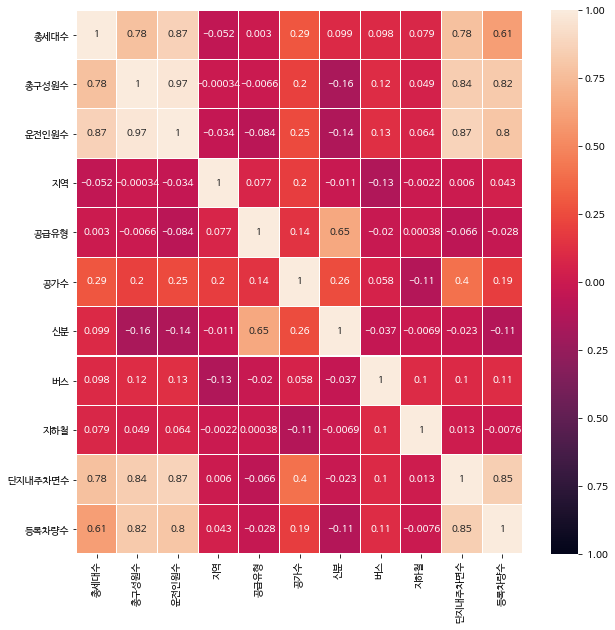

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(new_train.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.01)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



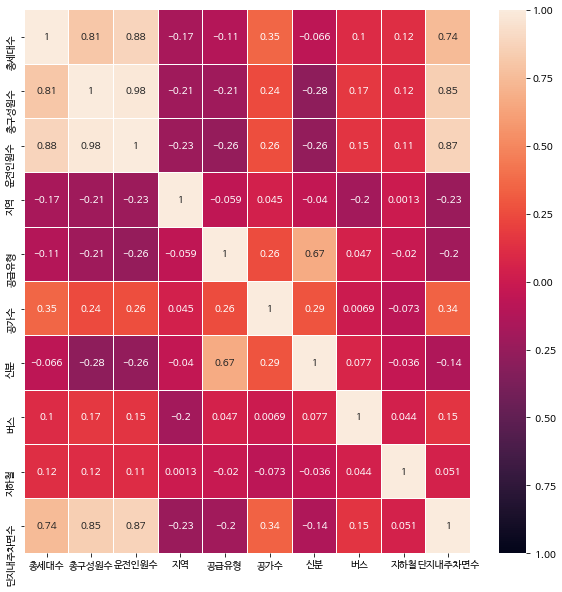

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(new_test.corr(), vmin=-1, vmax=1, annot=True, linewidths=0.01)

In [ ]:
new_train.columns

Index(['단지코드', '총세대수', '총구성원수', '운전인원수', '지역', '공급유형', '공가수', '신분', '버스',
       '지하철', '단지내주차면수', '등록차량수'],
      dtype='object')

In [ ]:
new_test

,단지코드,총세대수,총구성원수,운전인원수,지역,공급유형,공가수,신분,버스,지하철,단지내주차면수
0,C1072,754.0,1696.0,1696.0,2.0,0.0,14.0,7.0,2.0,0.0,683.0
1,C1128,1354.0,2997.0,2997.0,2.0,0.0,9.0,7.0,3.0,0.0,1216.0
2,C1456,619.0,1329.0,1285.0,7.0,0.0,18.0,0.0,16.0,0.0,547.0
3,C1840,593.0,1228.0,1228.0,3.0,0.0,7.0,0.0,3.0,0.0,543.0
4,C1332,1297.0,2746.0,2746.0,2.0,0.0,11.0,7.0,2.0,0.0,1112.0
...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,514.5,514.5,8.0,0.0,17.0,7.0,4.0,0.0,270.0
146,C1266,596.0,856.0,856.0,10.0,0.0,35.0,7.0,1.0,0.0,593.0
147,C2152,120.0,147.0,147.0,4.0,2.0,9.0,2.0,1.0,0.0,40.0
148,C1267,675.0,920.0,920.0,0.0,0.0,38.0,7.0,1.0,0.0,467.0


### **학습 및 추론**
--- 


In [ ]:
X_train = new_train.iloc[:, 1:-1]
Y_train = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

In [ ]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": seed,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2)
    model = CatBoostRegressor(**params_cat)
    model.fit( x_train, y_train, eval_set=(x_valid, y_valid),
        early_stopping_rounds=10,
        use_best_model=True,
        verbose=False
    )
    pred = model.predict(x_valid)
    score = mean_absolute_error(y_valid, pred)

    return score

sampler = TPESampler(seed=seed)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
study.best_value, study.best_trial.params

[I 2021-07-30 05:39:05,970] A new study created in memory with name: cat_opt
[I 2021-07-30 05:39:06,633] Trial 0 finished with value: 128.38356910115613 and parameters: {'max_depth': 9, 'colsample_bylevel': 0.943037873274484, 'subsample': 0.7219343632501507, 'min_child_samples': 57, 'max_bin': 327}. Best is trial 0 with value: 128.38356910115613.
[I 2021-07-30 05:39:08,679] Trial 1 finished with value: 139.8479184574206 and parameters: {'max_depth': 11, 'colsample_bylevel': 0.8875174422525385, 'subsample': 0.9242411005474558, 'min_child_samples': 97, 'max_bin': 315}. Best is trial 0 with value: 128.38356910115613.
[I 2021-07-30 05:39:13,342] Trial 2 finished with value: 145.7617128389086 and parameters: {'max_depth': 13, 'colsample_bylevel': 0.9057789839505809, 'subsample': 0.6976311927657526, 'min_child_samples': 93, 'max_bin': 221}. Best is trial 0 with value: 128.38356910115613.
[I 2021-07-30 05:39:13,465] Trial 3 finished with value: 170.78988694340487 and parameters: {'max_depth':

(88.63942003501033,
 {'colsample_bylevel': 0.8874063907598683,
  'max_bin': 400,
  'max_depth': 6,
  'min_child_samples': 10,
  'subsample': 0.7883418371490853})

In [ ]:
cat = CatBoostRegressor(**study.best_trial.params)

In [ ]:
skf = StratifiedKFold(n_splits=4)
scores = []
preds = []
for train_index, test_index in skf.split(X_train, Y_train) : 
    cat.fit(X_train.iloc[train_index], Y_train.iloc[train_index], use_best_model=True,
            eval_set=(X_train.iloc[test_index], Y_train.iloc[test_index]), verbose = 0)
    score = mean_absolute_error(Y_train, cat.predict(X_train))
    scores.append(score)
    pred = cat.predict(x_test)
    preds.append(pred)
scores, np.mean(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=4.



([61.849245762145934, 46.58904425716819, 84.98733352346078, 73.35969870924312],
 66.69633056300451)

In [ ]:
np.mean(preds, axis = 0)

array([ 720.074634  , 1264.26093736,  531.10885029,  579.17437397,
       1204.39574974, 1833.77153838, 1076.76260671,  539.96167734,
        311.93999995,  299.44716836,  475.18752041,  251.44030484,
        410.06720639,  269.45764517,  399.96775611,  248.79961241,
        439.99215869,  272.76203064,  175.27540638,  695.54831119,
        241.36097993,  489.02324264,  489.15079837,  467.7884285 ,
        392.46752964,  162.67475853,  302.98024295,  594.43874178,
        437.19871717,  511.37432905,  996.66245336,  154.08327769,
        446.37963626,  208.46581034,  131.75495059,  298.75699992,
        380.84408325,  567.27080714,  824.79198505,  332.83670278,
        443.26372855,  506.56596095,  477.38146623,  565.07221719,
        789.959587  , 1262.51974012,  490.37039938,  590.21171053,
        377.22546743,  342.28285303,  777.59210431,  282.79461581,
       1118.83322821,  595.09187579,  654.46871924,  281.37695474,
        689.23011327,  258.42788788,  465.11749499,  170.71759

In [ ]:
submission['num'] = np.mean(preds, axis = 0)

In [ ]:
submission

,code,num
0,C1072,720.074634
1,C1128,1264.260937
2,C1456,531.108850
3,C1840,579.174374
4,C1332,1204.395750
...,...,...
145,C2456,228.162678
146,C1266,451.228562
147,C2152,18.996575
148,C1267,393.180991


In [ ]:
submission.to_csv(result_path + result_file, index=False)